In [203]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [204]:
stock = "RR.L.csv"
train = pd.read_csv("../data/train/" + stock).set_index("Date")
validation = pd.read_csv("../data/validation/" + stock).set_index("Date")
test = pd.read_csv("../data/test/" + stock).set_index("Date")
train = pd.concat([train, validation], axis = 0)
train

,Open,High,Low,Close,Adj Close,Volume,Change[%]
Date,,,,,,,
2017-01-03,0.482997,0.479080,0.484905,0.470506,0.452145,0.034897,0.000000
2017-01-04,0.482565,0.471923,0.477626,0.468391,0.450099,0.033528,-0.373130
2017-01-05,0.472647,0.462661,0.457500,0.444714,0.427189,0.116681,-4.194755
2017-01-06,0.457122,0.452137,0.457928,0.454016,0.436190,0.067813,1.720118
2017-01-09,0.464884,0.461028,0.465208,0.462895,0.444781,0.050291,1.614118
...,...,...,...,...,...,...,...
2024-01-31,0.672262,0.658226,0.664609,0.646145,0.646145,0.069847,-1.921196
2024-02-01,0.656177,0.653564,0.654876,0.640231,0.640231,0.199965,-0.796821
2024-02-02,0.664471,0.665096,0.665358,0.668323,0.668323,0.352898,3.815269


__Date Embedding and cyclical transformation__

In [205]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [206]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

__Creating data loader__

In [207]:
def createSequence(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)
        yData.append(dataY[(lengthX + i):(lengthX + predictionHorizont + i)].values)
    return xData, yData

features = len(train.iloc[0])
samplesForPrediction = 2
samplesPredicted = 1
xTrain, yTrain = createSequence(train, train["Close"], samplesForPrediction, samplesPredicted)
xValid, yValid = createSequence(validation, validation["Close"], samplesForPrediction, samplesPredicted)
xTest, yTest = createSequence(test, test["Close"], samplesForPrediction, samplesPredicted)

In [208]:
xTrain = torch.Tensor(xTrain).to(device)
yTrain = torch.Tensor(yTrain).to(device)
xValid = torch.Tensor(xValid).to(device)
yValid = torch.Tensor(yValid).to(device)
xTest = torch.Tensor(xTest).to(device)
yTest = torch.Tensor(yTest).to(device)

__Model__

In [209]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.LSTM(input_size = samplesForPrediction*features, hidden_size = 8, num_layers = 2, device = device)
        self.relu = nn.ReLU()
        self.out = nn.Linear(8, 1, device = device)

    def forward(self, x):
        x = self.flatten(x)
        x, _ = self.l1(x)
        x = self.relu(x)
        out = self.out(x)
        return out

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): LSTM(14, 8, num_layers=2)
  (relu): ReLU()
  (out): Linear(in_features=8, out_features=1, bias=True)
)


In [210]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(xTrain, yTrain), shuffle=False, batch_size=1)

In [211]:
def trainLoop(epochs):
    model.train()
    for epoch in range(epochs):
        for inputData, desired in loader:
            pred = model(inputData)
            loss = loss_fn(pred, desired)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        model.eval()
        with torch.no_grad():
            y_pred = model(xTrain)
            train_rmse = loss_fn(y_pred, yTrain)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {train_rmse}')

trainLoop(12)


Epoch [1/12], Loss: 0.3637707531452179
Epoch [2/12], Loss: 0.32153937220573425
Epoch [3/12], Loss: 0.2794274091720581
Epoch [4/12], Loss: 0.23831522464752197
Epoch [5/12], Loss: 0.19865107536315918
Epoch [6/12], Loss: 0.1610865443944931
Epoch [7/12], Loss: 0.12480086088180542
Epoch [8/12], Loss: 0.0901021957397461
Epoch [9/12], Loss: 0.06148671731352806
Epoch [10/12], Loss: 0.042632006108760834
Epoch [11/12], Loss: 0.03502082824707031
Epoch [12/12], Loss: 0.0376456193625927


__Testing__

Total Mean Squared Error: 0.037645623087882996


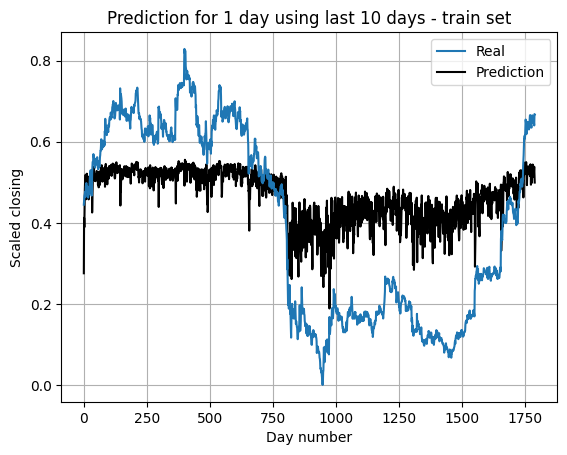

In [212]:
# Make predictions
y_pred = model(xTrain)

y_pred = y_pred.detach().numpy()


# Calculate the mean squared error across all outputs
mse_total = mean_squared_error(yTrain.detach().numpy(), y_pred)
print(f'Total Mean Squared Error: {mse_total}')

set = 5*2
real = np.concatenate(yTrain.detach().numpy()[::1])
predictions = np.concatenate(y_pred[::1])

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()

